This Script Resizes Both the spectral and mask images, performs image augmentation by doing rotation. 
Then Save the data in the respective files. 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import spectral.io.envi as envi
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn import preprocessing
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from pathlib import Path
from PIL import Image
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout
import h5py
from skimage.transform import resize
from skimage.transform import rotate
from skimage.transform import  AffineTransform,warp
from keras.preprocessing.image import ImageDataGenerator
import os 

In [12]:
datafolderpath="/../../../data/mudahmad/HSI_Human_Brain_Database_IEEE_Access/"
sub_folder_im_path = "/../../../data/mudahmad/256_size_images/"
test_path='/../../../data/mudahmad/'
tumorpath= '/../../../data/mudahmad/Tumor Files/'
nontumorpath= '/../../../data/mudahmad/Non Tumor Files/'


All Patient Data Alotment

In [15]:
# patientdata=[{pat_no:filddata },{}]
# This is done for the later processing and creation of resized and augmentated images. 

def createPatientFileData(p):
    patientdata=[]
    for path in Path(p).iterdir():
        if not path.is_file():
            patientfiledata={}
            patientfiledata['pat_no']=path.name
            patientdata.append(patientfiledata)
            for subfolpath in Path(path).iterdir():
                if subfolpath.name == "darkReference":
                    patientfiledata['dark_ref']=subfolpath
                elif subfolpath.name == "darkReference.hdr":
                    patientfiledata['dark_ref_hdr']=subfolpath
                if subfolpath.name == "whiteReference":
                    patientfiledata['white_ref']=subfolpath
                elif subfolpath.name == "whiteReference.hdr":
                    patientfiledata['white_ref_hdr']=subfolpath
                elif subfolpath.name == "gtMap":
                    patientfiledata['gt_map']=subfolpath
                elif subfolpath.name == "gtMap.hdr":
                    patientfiledata['gt_map_hdr']=subfolpath
                elif subfolpath.name == "gtMap.jpg":
                    patientfiledata['gt_map_jpg']=subfolpath
                elif subfolpath.name == "raw":
                    patientfiledata['raw_ref']=subfolpath 
                elif subfolpath.name == "raw.hdr":
                    patientfiledata['raw_hdr']=subfolpath 
                elif subfolpath.name == "image.jpg":
                    patientfiledata['image']=subfolpath 
                elif subfolpath.name == "cropimage.jpg":
                    patientfiledata['crop_im']=subfolpath 
                else:
                    pass
                
    return patientdata
        
    


All data

In [ ]:
patientdata=[]

patientdata=createPatientFileData(datafolderpath) 

Tumor Data

In [20]:
tumordata=[]
tumordata=createPatientFileData(tumorpath) 


Non Tumor Data

In [22]:
nontumordata=[]
nontumordata=createPatientFileData(nontumorpath)


In [26]:
# Save spec Data. 
def saveSpecData(spectraldata,path,foldername,filename):
    
    with open(path+foldername+"/"+filename, 'wb') as f:
        np.save(f,spectraldata)
#     with open(path+foldername+"/"+filename, 'rb') as f:
#         a = np.load(f,allow_pickle=True)
#         print(a.shape)
# Save Mask Data
def maskImSave(im,foldername,filename,ang,dim):
    filename=filename+".npy"
    with open(datafolderpath+foldername+"/"+filename, 'wb') as f:
        np.save(f,im)
     

In [23]:
# Rizing All spectral data to 256,256 dim. And Saving data in file. 
def resizeSpecData(newdim=256,data=[]):
    if spectral_data.shape[0]<256 or spectral_data.shape[1]<256:
        resized = resize(spectral_data, (newdim, newdim))
    else:
        resized= resize(spectral_data, (256, 256),anti_aliasing=True)
    return resized
    

In [24]:
def resizeMaskIm(newdim,hdr,maskim):
    mask = envi.open(hdr, maskim)
    maskarr= np.array(mask.load())

    if maskarr.shape[0]<256 or maskarr.shape[1]<256:
        resized = resize(maskarr, (newdim, newdim))
    else:
        resized= resize(maskarr, (256, 256),anti_aliasing=True)
    return resized

In [25]:
# PrePrpcess Spectral Data
# Stage 1
def preProcessSpecDataStep1(dark_hdr,dark,white_hdr,white,raw_hdr,raw):
    dark_ref = envi.open(dark_hdr, dark)
    white_ref = envi.open(white_hdr, white)
    spim = envi.open(raw_hdr, raw)
   

    white_nparr = np.array(white_ref.load())
    dark_nparr = np.array(dark_ref.load())
    spim = np.array(spim.load())
  
    
    spim_arr = 100 *   np.divide(
    np.subtract(spim, dark_nparr),
    np.subtract(white_nparr, dark_nparr))

    # Band Removed from 0 to 50 and from 750 to 826
    spectral_data=spim_arr[:,:,50:750]
    return spectral_data

    

Rotate Spectral Data Images by 30,45,60,75,90  

In [26]:
def specRotation(spec,datafolderpath,foldername,dim):
    rotations=[30,45,60,75,90,180,270]
    for ang in rotations:
        rotated_spec = rotate(spec, angle=ang)
        filename='spec_'+dim+'_rot_'+str(ang)+".npy"
        saveSpecData(rotated_spec,datafolderpath,foldername,filename)
        
def maskRotation(im,datafolderpath,foldername,dim):
    rotations=[30,45,60,75,90,180,270]
    for ang in rotations:
        rotated_im = rotate(im, angle=ang)
        filename="mask_"+dim+"_rot_"+str(ang)
        maskImSave(rotated_im,foldername,filename,ang,dim)


In [27]:
for dic in patientdata:
    
    spectral_data=preProcessSpecDataStep1(dic['dark_ref_hdr'],dic['dark_ref'],
                       dic['white_ref_hdr'],dic['white_ref'],
                       dic['raw_hdr'], dic['raw_ref'])
    print(spectral_data.shape)
    # Resize Spectral Data
    spectral_data=resizeSpecData(256,spectral_data)
    foldername=dic['pat_no']
    filename="spec_256.npy"
    
    # Save Spectral data of 256 without aug
    saveSpecData(spectral_data,datafolderpath,foldername,filename)
    
    #Rotate spec data by different degrees and save in patietn folder file.  
    specRotation(spectral_data,datafolderpath,foldername,"256")
    # Resize Mask Image
    maskim= resizeMaskIm(256,dic['gt_map_hdr'], dic['gt_map'])
    # Converting to int type. 
    maskim = maskim.astype(int)
    # Save 
    filename="mask_256"
    maskImSave(maskim,foldername,filename,0,"256")
    # Rotate And Save 
    maskRotation(maskim,datafolderpath,foldername,"256")

    break
    

    

(389, 345, 700)
(483, 488, 700)
(582, 400, 700)
(460, 549, 700)
(480, 553, 700)
(371, 461, 700)
(443, 497, 700)
(445, 498, 700)
(298, 253, 700)
(317, 244, 700)
(376, 494, 700)
(335, 323, 700)
(335, 326, 700)
(315, 321, 700)
(383, 297, 700)
(414, 292, 700)
(441, 399, 700)
(479, 462, 700)
(510, 434, 700)
(601, 535, 700)
(378, 330, 700)
(452, 334, 700)
(448, 324, 700)
(433, 340, 700)
(597, 527, 700)
(611, 527, 700)
(592, 471, 700)
(473, 403, 700)
(340, 324, 700)
(493, 476, 700)
(422, 398, 700)
(482, 408, 700)
(482, 390, 700)
(365, 371, 700)
(399, 342, 700)
(382, 285, 700)


In [54]:
maskim.shape

(256, 256, 1)

(256, 256, 700)
(256, 256, 700)


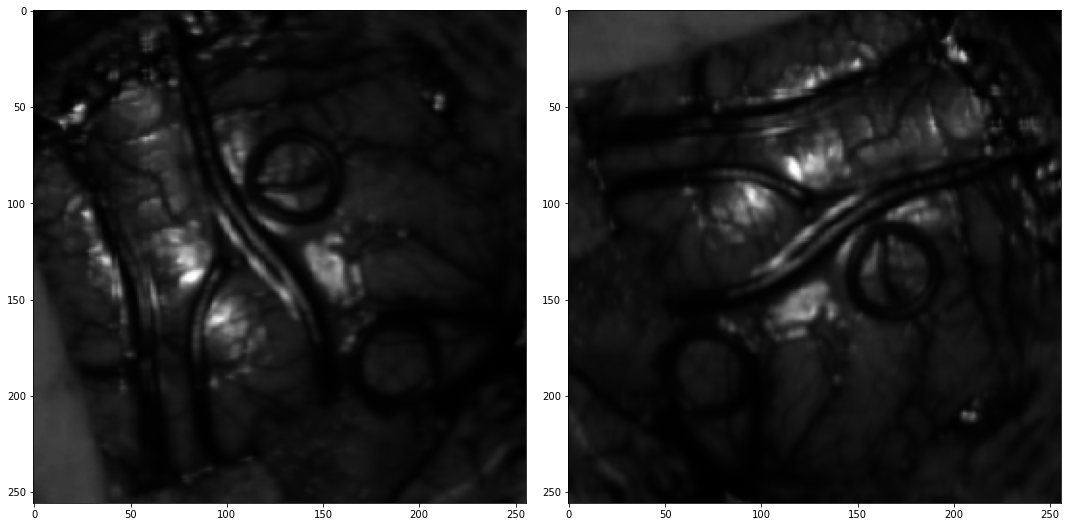

In [50]:
with open(datafolderpath+"/004-02/spec_rot_90.npy", 'rb') as f:
        rot = np.load(f,allow_pickle=True)
        print(rot.shape)
with open(datafolderpath+"/004-02/resize_256_spec.npy", 'rb') as f:
        spec = np.load(f,allow_pickle=True)
        print(spec.shape)
        
f, axs = plt.subplots(1,2,figsize=(15,15))
plt.tight_layout()
axs[0].imshow(rot[:,:,200],cmap='gray')
axs[1].imshow(spec[:,:,200],cmap='gray')


In [9]:
def showSpecImages(spec,augim):
    f, axs = plt.subplots(1,2,figsize=(15,15))
    plt.tight_layout()
    axs[0].imshow(augim[:,:,200],cmap='gray')
    axs[1].imshow(spec[:,:,200],cmap='gray')


In [8]:
def loadSpecFile(path,filename):
    with open(path+filename, 'rb') as f:
        spec = np.load(f,allow_pickle=True)
        return spec
spec=loadSpecFile(test_path,'test_spec.npy')
print(spec.shape)

(256, 256, 700)


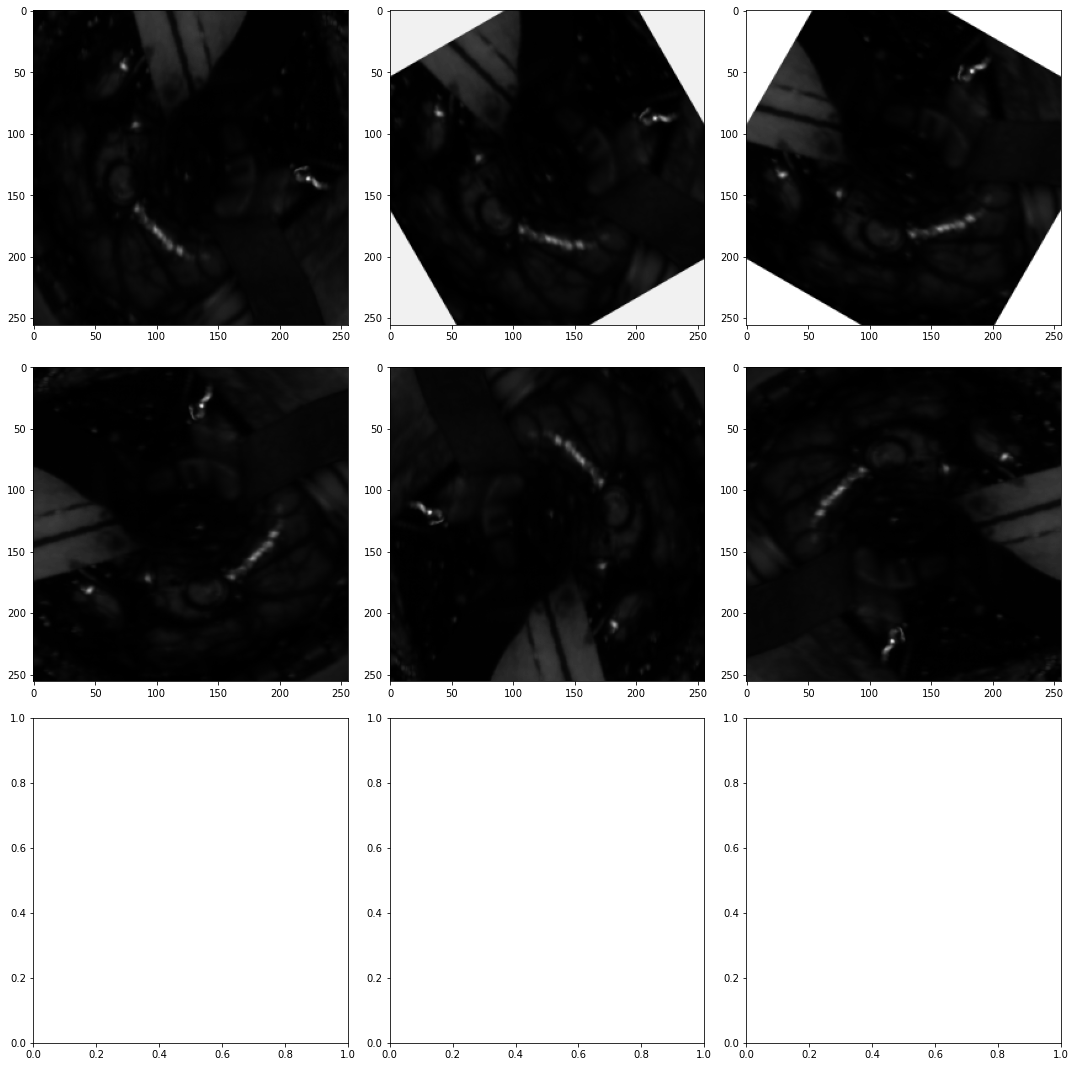

In [36]:
rotations=[10,15,20,25,30,35,40,45,60,75,90]



rotated_spec = rotate(spec, angle=30,cval=255)
rotated_spec2 = rotate(spec, angle=60,cval=255)
rotated_spec3 = rotate(spec, angle=90,cval=255)
rotated_spec4 = rotate(spec, angle=180,cval=255)
rotated_spec5 = rotate(spec, angle=270,cval=255)



    
f, axs = plt.subplots(3,3,figsize=(15,15))
axs=axs.flatten()
plt.tight_layout()
axs[0].imshow(spec[:,:,200],cmap='gray')
axs[1].imshow(rotated_spec[:,:,200],cmap='gray')
axs[2].imshow(rotated_spec2[:,:,200],cmap='gray')
axs[3].imshow(rotated_spec3[:,:,200],cmap='gray')
axs[4].imshow(rotated_spec4[:,:,200],cmap='gray')
axs[5].imshow(rotated_spec5[:,:,200],cmap='gray')